In [ ]:
from sklearn import linear_model

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np      


In [1]:
import matplotlib.pyplot as plt
import torch as tc
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import numpy as np

# v= Constante

## ML-std

In [ ]:
def eq_movimento(x_0,v_,t_): 
    return  x_0 + v_*t_

t = np.linspace(0,10)  

plt.plot(t,eq_movimento(x_0=0,v_=2,t_=t),".")
plt.plot(t,eq_movimento(x_0=0,v_=1,t_=t),".")
plt.plot(t,eq_movimento(x_0=1,v_=1,t_=t),".")

plt.show()

In [ ]:
t = np.linspace(0,10).reshape((-1, 1))  
y = eq_movimento(x_0=0,v_=2,t_=t)

reg = linear_model.LinearRegression()
reg.fit(t,y)# FITANDO 
print("a: ",reg.coef_)
print("b: ",reg.intercept_)


In [ ]:
from sklearn.tree import DecisionTreeRegressor

RT = DecisionTreeRegressor(criterion = "squared_error")
RT.fit(t,y)# FITANDO 

t_tes = np.linspace(0,10).reshape((-1, 1))  
predição = RT.predict(t_tes)

plt.plot(t,y,"-")
plt.plot(t_tes,predição,".")

plt.show()

## ML-NN

In [ ]:
class Regressao(nn.Module):
    def __init__(self,neuronio):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_3 = nn.Linear(neuronio,1)
        self.A_layer = nn.ReLU()

    def forward(self, x):
        x = self.A_layer(self.layer_1(x))
        x = self.A_layer(self.layer_3(x))
        return x  

In [ ]:
class Loss_parametro(nn.Module):
    def __init__(self):
        super(Loss_parametro, self).__init__()
    def forward(self, inputs, targets,outputs):
        # mudar de [N,1] para [N]
        # função 1° grau: x- x0 -vt = 0
        funcao_1_grau = targets - targets[0] - outputs*inputs
        loss_solution = tc.mean( abs(funcao_1_grau) )
        # podemos impor que independe do input o parametro deve ser igual  
        # v_medio = output[:,1].mean()
        # loss_const = tc.mean((output[:,1] - v_medio) ** 2)
        return loss_solution
    
class Loss_edo(nn.Module):
    def __init__(self,rede_neural,velocidade):
        super(Loss_edo, self).__init__()
        self.rede = rede_neural
        self.v = velocidade
        
    def forward(self, inputs, targets):
        output ,derivadas = tc.autograd.functional.jvp(self.rede ,inputs ,v=tc.ones(len(inputs),1),create_graph=True) # v é um vetor unitario para retorna apenas o jacobiano
        # condição inicial x(0)
        loss_ic = (output[0] - targets[0])**2
        
        # dividido pela tamanho do dados de entrada
        loss_ic = loss_ic/len(inputs)
        # Derivada da função em relação a entrada 
        # edo : dx/dt = v
        # estamos usando [1:] para escluir a condição inicial
        loss_edo = tc.mean( (derivadas[1:] - self.v )**2 )

        return loss_ic + loss_edo

Aprendendo a função com a edo 

In [ ]:
def eq_movimento(x_0,v_,t_): 
    return  x_0 + v_*t_

# Criando os dados de treino
x_train = tc.linspace(0,10,50).reshape(50,1)
y_train =  eq_movimento(x_0=0,v_=1,t_=x_train)

rede1 = Regressao(20) # rede da função
opt1 = tc.optim.Adam(params=rede1.parameters(),lr=0.01)  # rede da função
loss_fn1  = Loss_edo(rede1,velocidade=1)

epochs = 10000
for epoch in range(epochs):
    rede1.train()
    loss = loss_fn1(x_train, y_train)
    opt1.zero_grad()
    loss.backward()
    opt1.step() 

#rede 1 é a função
loss_fn = nn.MSELoss()
rede1.eval()
with tc.inference_mode():
    prediçao = rede1(x_train)
    loss = loss_fn( prediçao,y_train)
    print(f"| Train Loss: {loss} |")
    
plt.plot(x_train,y_train,"k-" ,label="teorico")
plt.plot(x_train, prediçao,".",label="predição" )
plt.legend()
plt.show()  

Aprendendo o valor da constante

In [ ]:
def eq_movimento(x_0,v_,t_): 
    return  x_0 + v_*t_

# Criando os dados de treino
x_train = tc.linspace(0,10,20).reshape(20,1)
y_train =  eq_movimento(x_0=0,v_=1,t_=x_train)


rede2 = Regressao(10) # rede dos parametros 
opt2 = tc.optim.Adam(params=rede2.parameters(),lr=0.01) # rede dos parametros 
loss_fn2  = Loss_parametro()

epochs = 10000
for epoch in range(epochs):
    rede2.train()
    y_preds = rede2(x_train)
    loss = loss_fn2(inputs=x_train,targets=y_train, outputs=y_preds)
    opt2.zero_grad()
    loss.backward()
    opt2.step() 
    
    
    rede1.train()
    loss = loss_fn1(x_train, y_train)
    opt1.zero_grad()
    loss.backward()
    opt1.step() 

#rede 2 é a parametro
loss_fn = nn.MSELoss()
rede2.eval()
with tc.inference_mode():
    prediçao = rede2(x_train)
    loss = loss_fn(y_train[0] + prediçao*x_train,y_train)
    print(f"| Train Loss: {loss} |")
    print(prediçao[:5])
plt.plot(x_train,y_train,"k-" ,label="teorico")
plt.plot(x_train,y_train[0] + prediçao*x_train,".",label="predição" )
plt.show()  

# a =Constante

## ML-std

In [ ]:
def eq_movimento(x_0,v_,a_,t_):
    return  x_0 + v_*t_ + a_*t_**2/2

t = np.linspace(0,1.4).reshape((-1, 1))    
y = eq_movimento(x_0=10,v_=0,a_=-9.81,t_=t)
plt.plot(t,y,".")
plt.show()

Regressão linear

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(t,y)# FITANDO 
print("a: ",reg.coef_)
print("b: ",reg.intercept_)

plt.plot(t,y,".")
plt.plot(t,reg.intercept_[0] + reg.coef_[0][0]*t,".")
plt.show()

Decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

RT = DecisionTreeRegressor(criterion = "squared_error")
RT.fit(t,y)# FITANDO 


predição = RT.predict(t)

plt.plot(t,y,"-")
plt.plot(t,predição,".")

plt.show()

Regressaõ polinomia 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2)

t_poly = poly.fit_transform(t)

R = linear_model.LinearRegression()
train_y_ = R.fit(t_poly, y)
# The coefficients
print ('Coefficients: ', R.coef_)
print ('b: ',R.intercept_)

predição = R.intercept_[0]+ R.coef_[0][1]*t+ R.coef_[0][2]*t**2
plt.plot(t,y,"-")
plt.plot(t,predição,".")

plt.show()

## ML-Rede neural 

In [2]:
class Regressao(nn.Module):
    def __init__(self,neuronio):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_2 = nn.Linear(neuronio,neuronio)
        self.layer_3 = nn.Linear(neuronio,1)
        self.A_layer = nn.Tanh()

    def forward(self, x):
        x = self.A_layer(self.layer_1(x))
        x = self.A_layer(self.layer_2(x))
        x = self.layer_3(x)
        return x
    
class loss_pinn1(nn.Module):
    """_summary_
    Essa loss utiliza a saida da rede neural como uma função quedeve ser solução de uma equação.
    Nesse caso é a solução da edo de 2° ordem.
    
            d^2 x/dt^2 = a
    
    Será fornecido  o valor de a, condição inicial da posição e velocidade.

    Args:
        nn (_type_): _description_
    """
    def __init__(self, t, y_true, aceleracao, velocity=None):
        super(loss_pinn1,self).__init__()
        self.t_ = t
        self.v_ = velocity
        self.a_ = aceleracao
        self.y_true_ = y_true

    def forward(self,y_pred):
        dydt = tc.autograd.grad(y_pred, self.t_, grad_outputs=tc.ones_like(y_pred), create_graph=True)[0]
        d2ydt2 = tc.autograd.grad(dydt, self.t_, grad_outputs=tc.ones_like(y_pred), create_graph=True)[0]
        
        # Condiçao incial da posição
        loss_ic_x0 = (y_pred[0] -self.y_true_[0] )**2
        # Condiçao incial da velocidade
        loss_ic_v0 = (dydt[0] -self.v_ )**2
        
        # Edo d^2 x/dt^2 = a
        loss_edo_xx = (d2ydt2 - self.a_)**2/len(self.t_)
        # Edo dx/dx = a
        #loss_edo_x = (dydt - self.a_)**2
        return tc.sum(loss_edo_xx) + loss_ic_x0 + loss_ic_v0
    
class loss_pinn2(nn.Module):
    """_summary_:
    Essa loss utiliza a saida da rede neural como um parâmetro da solução de uma equação.
    Nesse caso é a solução da edo de 2° ordem 
    
    -->>>  d^2x/dt^2 = a
    -->>> y(t) = x(0) + v(0)*t + at**2/2
    
    Será fornecido  o valor de cada instante de tempo , valor da posição e velocidade em t = 0.
    """
    def __init__(self,x_0,v_0, y_,t_):
        super().__init__()
        self.x0 = x_0
        self.v0 = v_0
        self.true_output = y_
        self.tempo = t_
        
    def forward(self, outputs_p,output_f=0,output_f2 = 0):
        # talvez adicionar a derivada 
        # y  =  x_0 + v_*t_ + a_*t_**2/2
        solution = (self.true_output - self.x0 -self.v0*self.tempo - outputs_p*self.tempo**2/2)**2
        solution_data =  (self.true_output- output_f)**2
        return tc.mean(solution) + tc.mean(solution_data)*output_f2


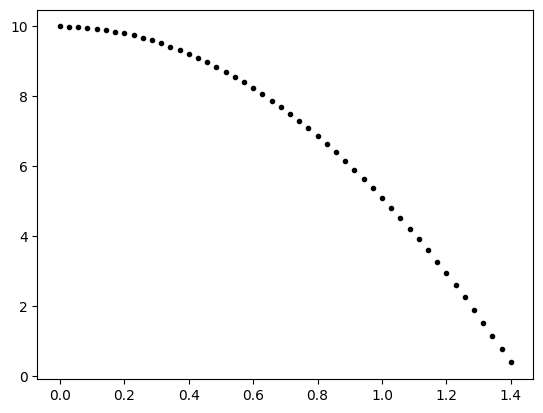

In [2]:
def eq_movimento(x_0,v_,a_,t_):
    return  x_0 + v_*t_ + a_*t_**2/2
device ='cuda'
N=50
# Criando os dados de treino
x_train = tc.linspace(0,1.4,N,requires_grad=True,device=device).reshape(N,1)
y_train =  eq_movimento(x_0=10,v_=0,a_=-9.81,t_=x_train)

# Visualizando os dados de treino

plt.plot(x_train.cpu().detach().numpy(),y_train.cpu().detach().numpy(),"k." )
plt.show()

Aprendendo a função com os dados 

In [ ]:
model = Regressao(neuronio=20).to(device=device)
loss_fn = nn.MSELoss()
optimizer = tc.optim.Adam(params=model.parameters(),lr=0.01)

epochs = 5000
for epoch in range(epochs):
    model.train()
    y_preds = model(x_train)
    loss = loss_fn(y_preds, y_train)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

model.eval()
with tc.inference_mode():
    y_preds_test = model(x_train)
    loss = loss_fn(y_preds_test,y_train)
    print(f"| Train Loss: {loss} | ")

plt.plot(x_train.cpu().detach().numpy(),y_train.cpu().detach().numpy(),"-")
plt.plot(x_train.cpu().detach().numpy(),y_preds_test.cpu().detach().numpy(),"k." )
plt.show()

aprendendo o parametro da equação(Aceleração)

In [ ]:
model = Regressao(neuronio=5,output=1,activation="tanh",h_layer=True).to(device=device)  
loss_fn = loss_pinn2(x_0=10,v_0=0,y_= y_train,t_=x_train)
optimizer = tc.optim.Adam(params=model.parameters(),lr=0.01)

LOSS = []
epochs = 2000
for epoch in range(epochs):
    model.train()
    y_preds = model(x_train)
    loss = loss_fn(y_preds[:])
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    LOSS.append(loss.cpu().detach().numpy())

model.eval()
with tc.inference_mode():
    y_preds = model(x_train)
    loss = loss_fn(y_preds[0,0],y_preds[:,0],1)
    print(f"| Train Loss: {loss} | ")
    
x = x_train.cpu().detach().numpy()
y = y_train.cpu().detach().numpy()

aceleracao = y_preds[0].cpu().detach().numpy()
#funcao = y_preds[:,1].cpu().detach().numpy()
y_predic = 10 +aceleracao*x**2/2

plt.plot(x,y,"k-",label="teorico")
plt.plot(x,y_predic,"r--", label=f"a:{np.round(aceleracao,decimals=2)}" )
#plt.plot(x,funcao)
plt.legend()
plt.show()
plt.plot(LOSS);plt.show()

In [ ]:
model = Regressao(neuronio=15).to(device)
loss_fn = loss_pinn1(x_train, y_train, aceleracao=-9.81, velocity=0.0)
optimizer = tc.optim.Adam(params=model.parameters(),lr=0.01)

for epoch in range(1000):
  model.train()
  y_pred  = model(x_train)
  loss    = loss_fn(y_pred)
  
  optimizer.zero_grad()
  loss.backward(retain_graph=True)
  optimizer.step()

x = x_train.cpu().detach().numpy()
y = y_train.cpu().detach().numpy()

y_pred = model(x_train)
y_pred = y_pred.cpu().detach().numpy()


fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(x,y,"k-",label="teorico")
ax[0].plot(x,y_pred,"r--",label="rede")
ax[0].legend()
ax[0].set_ylabel("y(t)")
ax[0].set_xlabel("t (time)")
ax[1].plot(LOSS)
ax[1].set_xlabel("epochs")
plt.show()


In [ ]:
#forma de derivar :
#model = Regressao(neuronio=10)
#derivada = [tc.autograd.functional.hessian(model,i)[0] for i in x_train] # Fuciona
#y_preds,derivada =tc.autograd.functional.hvp(model ,x_train[0],create_graph=True,strict=True)  # fuciona
